# UEFA Champions League Finals Data Overview

In [2]:
from bs4 import BeautifulSoup  # Import BeautifulSoup for HTML parsing
import requests  # Import requests for making HTTP requests
import pandas as pd  # Import pandas for data manipulation
import re  # Import regular expressions for text cleaning
import matplotlib.pyplot as plt # Import Matplotlib for plotting

# Define the URL of the Wikipedia page containing UEFA Champions League finals data
url = 'https://en.wikipedia.org/wiki/List_of_European_Cup_and_UEFA_Champions_League_finals'
response = requests.get(url)  # Send an HTTP request to fetch the page content

# Parse the HTML content of the page using BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find all tables with the class 'wikitable plainrowheaders sortable'
table = soup.find_all('table', class_='wikitable plainrowheaders sortable')

# Select the first table from the list
table_1 = table[0]

# Extract all rows from the table
rows = table_1.find_all('tr')

# Extract column headers from the first row of the table
headers = [th.get_text(strip=True) for th in rows[0].find_all('th')]

# Initialize an empty list to store row data
data = []
for row in rows[1:]:  # Iterate over all rows except the header row
    
    # Extract the season from the first column (header cell)
    season = row.find('th').get_text(strip=True) if row.find('th') else None

    # Extract all other column values
    cells = [cell.get_text(strip=True) for cell in row.find_all('td')]

    # Append extracted data as a new row in the dataset
    data.append([season] + cells)

# Create a DataFrame with the extracted data and appropriate column headers
df = pd.DataFrame(data, columns=headers)

display(df)

,Season,Country,Winners,Score,Runners-up,Country,Venue,Attend­ance[15]
0,1955–56,Spain,Real Madrid,4–3,Reims,France,"Parc des Princes, Paris, France","38,239"
1,1956–57,Spain,Real Madrid,2–0,Fiorentina,Italy,"Santiago Bernabéu, Madrid, Spain","124,000"
2,1957–58,Spain,Real Madrid,3–2†,Milan,Italy,"Heysel Stadium, Brussels, Belgium","67,000"
3,1958–59,Spain,Real Madrid,2–0,Reims,France,"Neckarstadion, Stuttgart, West Germany","72,000"
4,1959–60,Spain,Real Madrid,7–3,Eintracht Frankfurt,West Germany,"Hampden Park, Glasgow, Scotland","127,621"
...,...,...,...,...,...,...,...,...
65,2019–20,Germany,Bayern Munich,1–0,Paris Saint-Germain,France,"Estádio da Luz, Lisbon, Portugal",0[l]
66,2020–21,England,Chelsea,1–0,Manchester City,England,"Estádio do Dragão, Porto, Portugal","14,110[m]"
67,2021–22,Spain,Real Madrid,1–0,Liverpool,England,"Stade de France, Saint-Denis, France","75,000"
68,2022–23,England,Manchester City,1–0,Inter Milan,Italy,"Atatürk Olympic Stadium, Istanbul, Turkey","71,412"


# Cleaning and Structuring The Data

#### Handling Missing Values
- The rows from index 70 until the last row not important or useful, so it is better to delete them. Lets check if there any useful rows.

In [3]:
# displaying the null values
df[df.isnull().any(axis=1)]

,Season,Country,Winners,Score,Runners-up,Country,Venue,Attend­ance[15]
19,None,4–0&,"23,325",None,None,None,None,None


- About index 19:

In [4]:
df.loc[[18, 19]]

,Season,Country,Winners,Score,Runners-up,Country,Venue,Attend­ance[15]
18,1973–74,West Germany,Bayern Munich,1–1,Atlético Madrid,Spain,"Heysel Stadium, Brussels, Belgium","48,722"
19,None,4–0&,"23,325",None,None,None,None,None


- The 1974 European Cup final between Bayern Munich and Atlético Madrid was replayed because the original match, held on May 15, 1974, ended in a draw after extra time, and penalty shootouts had not yet been introduced for the final. (https://en.wikipedia.org/wiki/1974_European_Cup_final)


- The penalty shootouts existed before 1974, but they were not yet used to decide European Cup finals at that time. Penalty shootouts were introduced in European competitions in 1970, but UEFA still chose replays for finals. (https://www.britannica.com/sports/penalty-kick) (https://en.wikipedia.org/wiki/Penalty_shoot-out_(association_football)#Origins)


- In 1976, UEFA officially adopted penalty shootouts for the European Cup finals and beyond, meaning that if a final ended in a draw after extra time, it would go straight to penalties instead of a replay. (https://en.wikipedia.org/wiki/Penalty_shoot-out_(association_football)#Development)


- Therefore, I decided to accept the second replayed match as the valid match.

In [5]:
# Handlle row 18

df.loc[18, 'Attend­ance[15]'] = df.loc[19, 'Winners']
df.loc[18, 'Score'] = df.loc[19, 'Country'][0]

In [6]:
# Display row 18 to make sure
df.loc[[18]]

,Season,Country,Winners,Score,Runners-up,Country,Venue,Attend­ance[15]
18,1973–74,West Germany,Bayern Munich,4–0&,Atlético Madrid,Spain,"Heysel Stadium, Brussels, Belgium","23,325"


In [7]:
# Remove the null values
df = df.dropna().reset_index(drop=True)

#### Renaming and Formatting Columns

In [8]:
# Rename the 'Country' and Attendance columns
df.columns = ['Season', 'Winner_Country', 'Winners', 'Score', 'Runners-up', 'Runner_Up_Country', 'Venue', 'Attendance']

#### Cleaning Attendance Column

In [9]:
# Clean and convert 'Attendance' column to int
df['Attendance'] = df['Attendance'].str.replace(r'\D', '', regex=True).astype(int)

#### Extracting and Cleaning Match Scores

Form the sorce of data (https://en.wikipedia.org/wiki/List_of_European_Cup_and_UEFA_Champions_League_finals#List_of_finals), The key:
   - `†` → **Won in extra time**
   - `*` → **Won on penalties**
   - `&` → **Won after a replay**
   - No symbol → **Won in regular time**

In [10]:
# Determine match status
def get_match_status(score):
    if pd.isna(score) or not isinstance(score, str):
        return "Unknown"
    if "†" in score:
        return "Extra Time"
    elif "*" in score:
        return "Penalties"
    elif "&" in score:
        return "Replay"
    else:
        return "Regular Time"

df['Match_Status'] = df['Score'].apply(get_match_status)

In [11]:
# Clean Score column
df['Score'] = df['Score'].str.replace(r'[^0-9–]', '', regex=True)

In [12]:
# Extract winner and loser score
df[['Winner_Score', 'Loser_Score']] = df['Score'].str.split('–', expand=True).astype(int, int)

#### Calculating Match Statistics

In [13]:
# Calculate the absolute goal difference between the winner and the loser in each final
df['Goal_Difference'] = abs(df['Winner_Score'] - df['Loser_Score'])

# Calculate the total number of goals scored in each final
df['Total_number_of_goals'] = df['Winner_Score'] + df['Loser_Score']

#### Extracting Venue Details

In [14]:
# Extract stadium, city, and country names from the 'Venue' column and strip white spaces
df[['Stadium', 'City', 'Host_Country']] = df['Venue'].str.split(',', expand=True).apply(lambda x: x.str.strip())

#### Reordering Columns

In [15]:
# Reorder columns for better readability and structured analysis
columns = ['Season', 'Winner_Country', 'Winners','Score', 'Runners-up', 'Runner_Up_Country', 'Winner_Score', 'Loser_Score', 
           'Goal_Difference', 'Total_number_of_goals',
           'Match_Status','Venue', 'Stadium', 'City','Host_Country','Attendance']

df = df[columns]

In [16]:
df

,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,Match_Status,Venue,Stadium,City,Host_Country,Attendance
0,1955–56,Spain,Real Madrid,4–3,Reims,France,4,3,1,7,Regular Time,"Parc des Princes, Paris, France",Parc des Princes,Paris,France,38239
1,1956–57,Spain,Real Madrid,2–0,Fiorentina,Italy,2,0,2,2,Regular Time,"Santiago Bernabéu, Madrid, Spain",Santiago Bernabéu,Madrid,Spain,124000
2,1957–58,Spain,Real Madrid,3–2,Milan,Italy,3,2,1,5,Extra Time,"Heysel Stadium, Brussels, Belgium",Heysel Stadium,Brussels,Belgium,67000
3,1958–59,Spain,Real Madrid,2–0,Reims,France,2,0,2,2,Regular Time,"Neckarstadion, Stuttgart, West Germany",Neckarstadion,Stuttgart,West Germany,72000
4,1959–60,Spain,Real Madrid,7–3,Eintracht Frankfurt,West Germany,7,3,4,10,Regular Time,"Hampden Park, Glasgow, Scotland",Hampden Park,Glasgow,Scotland,127621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2019–20,Germany,Bayern Munich,1–0,Paris Saint-Germain,France,1,0,1,1,Regular Time,"Estádio da Luz, Lisbon, Portugal",Estádio da Luz,Lisbon,Portugal,0
65,2020–21,England,Chelsea,1–0,Manchester City,England,1,0,1,1,Regular Time,"Estádio do Dragão, Porto, Portugal",Estádio do Dragão,Porto,Portugal,14110
66,2021–22,Spain,Real Madrid,1–0,Liverpool,England,1,0,1,1,Regular Time,"Stade de France, Saint-Denis, France",Stade de France,Saint-Denis,France,75000
67,2022–23,England,Manchester City,1–0,Inter Milan,Italy,1,0,1,1,Regular Time,"Atatürk Olympic Stadium, Istanbul, Turkey",Atatürk Olympic Stadium,Istanbul,Turkey,71412


# Attendance Trends

#### Visualizing Attendance Over the Years

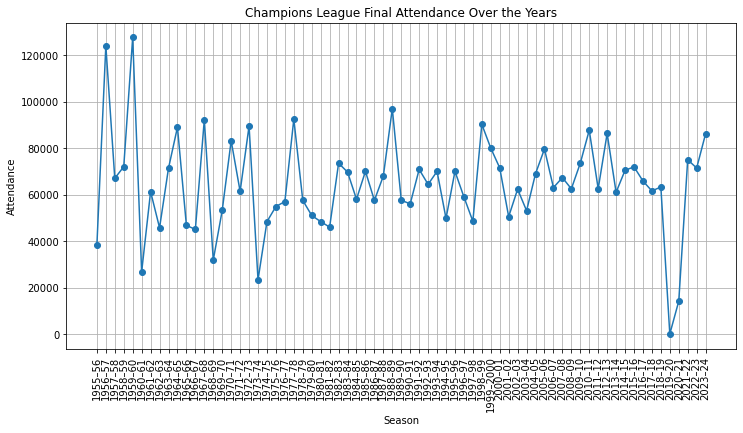

In [17]:
# Plot Champions League final attendance over the years

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sorted(list(df['Season'].unique())), df['Attendance'], marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel("Season")
plt.ylabel("Attendance")
plt.title("Champions League Final Attendance Over the Years")
plt.grid()
plt.show()

####  Top 10 Most Attended Champions League Finals

In [18]:
# Display the top 10 most attended Champions League finals

most_attended_matchs = df.sort_values('Attendance', ascending=False)[['Season', 'Attendance']]
print(most_attended_matchs.head(10))

     Season  Attendance
4   1959–60      127621
1   1956–57      124000
33  1988–89       97000
22  1977–78       92500
12  1967–68       92225
43  1998–99       90245
17  1972–73       89484
9   1964–65       89000
55  2010–11       87695
57  2012–13       86298


#### Bar Chart of Most Attended Finals

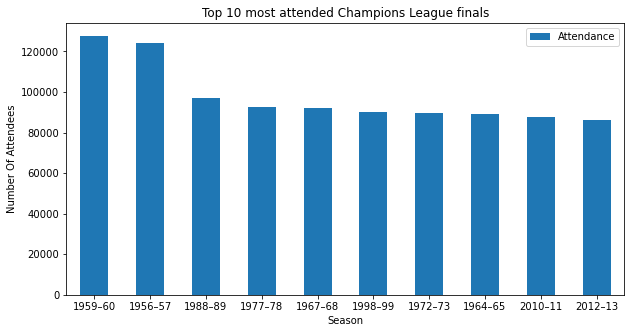

In [19]:
# Plot the top 10 most attended Champions League finals using a bar chart

most_attended_matchs.head(10).plot(kind='bar', x='Season', y='Attendance', figsize=(10, 5), title="Top 10 most attended Champions League finals", )
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.ylabel("Number Of Attendees")
plt.show()

# Top Stadiums Hosting UEFA Champions League Finals

#### Counting the Most Frequent Host Stadiums

In [20]:
# Count and display the top 10 stadiums that have hosted the most Champions League finals

stadium_counts = df['Stadium'].value_counts().reset_index().head(10)
stadium_counts.columns = ['Stadium', 'Finals_Hosted']

print(stadium_counts)

             Stadium  Finals_Hosted
0    Wembley Stadium              8
1           San Siro              4
2     Heysel Stadium              4
3  Santiago Bernabéu              4
4     Olympiastadion              4
5    Stadio Olimpico              4
6   Parc des Princes              3
7    Olympic Stadium              3
8    Stade de France              3
9      Praterstadion              3


#### Bar Chart of Top Host Stadiums

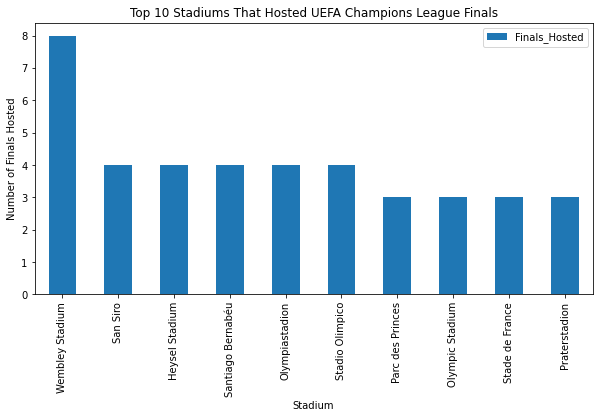

In [21]:
# Plot the top 10 stadiums that have hosted the most Champions League finals

stadium_counts.plot(kind='bar', x='Stadium', y='Finals_Hosted', figsize=(10, 5), title="Top 10 Stadiums That Hosted UEFA Champions League Finals")
plt.xlabel("Stadium")
plt.ylabel("Number of Finals Hosted")
plt.show()

# Champions League Winners

#### Top 10 Most Successful Clubs

In [22]:
# Display the top 10 most successful clubs based on the number of Champions League titles won

top_winners = df['Winners'].value_counts().reset_index().head(10)
top_winners.columns = ['Winner', 'Count']

print(top_winners)

              Winner  Count
0        Real Madrid     15
1              Milan      7
2      Bayern Munich      6
3          Liverpool      6
4          Barcelona      5
5               Ajax      4
6        Inter Milan      3
7  Manchester United      3
8            Chelsea      2
9  Nottingham Forest      2


#### Champions League Titles by Country

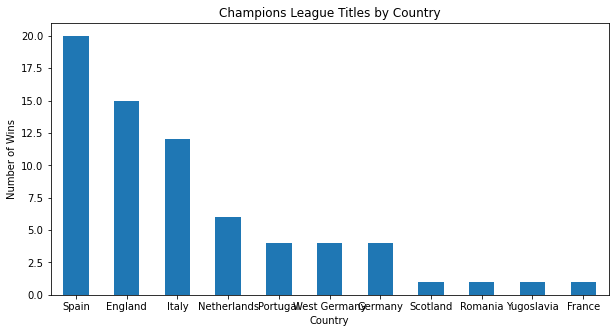

In [23]:
# Plot the number of Champions League titles won by each country

country_wins = df['Winner_Country'].value_counts()

plt.figure(figsize=(10, 5))
country_wins.plot(kind='bar')
plt.xlabel("Country")
plt.xticks(rotation=0)
plt.ylabel("Number of Wins")
plt.title("Champions League Titles by Country")
plt.show()

## Compare Winning Teams by Attendance

####  Top 10 Teams with the Highest Average Final Attendance

In [24]:
# Calculate and display the top 10 teams with the highest average final match attendance

team_attendance = df.groupby('Winners')['Attendance'].mean().sort_values(ascending=False)
print(team_attendance.head(10))

Winners
Manchester United    83260.000000
Inter Milan          77941.000000
Barcelona            74208.200000
Hamburger SV         73500.000000
Real Madrid          71742.466667
Manchester City      71412.000000
Ajax                 70936.750000
Steaua București     70000.000000
PSV Eindhoven        68000.000000
Liverpool            66637.500000
Name: Attendance, dtype: float64


#### Bar Chart of Teams with the Highest Final Attendance

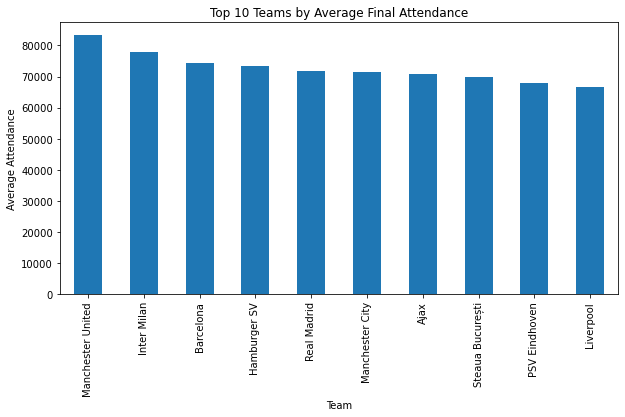

In [25]:
# Plot the top 10 teams with the highest average final match attendance

team_attendance.head(10).plot(kind='bar', figsize=(10, 5), title="Top 10 Teams by Average Final Attendance")
plt.xlabel("Team")
plt.ylabel("Average Attendance")
plt.show()

#### Champions League Wins by City

In [26]:
# Count how many times each team has won at each city
venue_wins = df.groupby(['Winners', 'City']) \
    .agg(Count=("Season", "count"), Seasons=("Season", lambda x: ", ".join(x))) \
    .reset_index()

# Sort by city and wins in descending order
venue_wins_sorted = venue_wins.sort_values(by='Count', ascending=False)

# Display the teams that won more than once in the same city
print(venue_wins_sorted[venue_wins_sorted.Count > 1])

        Winners         City  Count             Seasons
32    Liverpool         Rome      2    1976–77, 1983–84
59  Real Madrid  Saint-Denis      2  1999–2000, 2021–22
50  Real Madrid     Brussels      2    1957–58, 1965–66
6     Barcelona       London      2    1991–92, 2010–11
38        Milan       Athens      2    1993–94, 2006–07
52  Real Madrid      Glasgow      2    1959–60, 2001–02


# Scorelines

#### Most Common Scorelines in Champions League Finals

In [27]:
# Display the top 10 most common scorelines in Champions League finals

score_counts = df['Score'].value_counts().reset_index().head(10)
score_counts.columns = ['Score', 'Count']

print(score_counts)

  Score  Count
0   1–0     19
1   2–1     10
2   2–0      9
3   3–1      6
4   1–1      6
5   4–1      4
6   0–0      4
7   4–0      3
8   3–2      2
9   3–0      2


#### Bar Chart of Common Scorelines

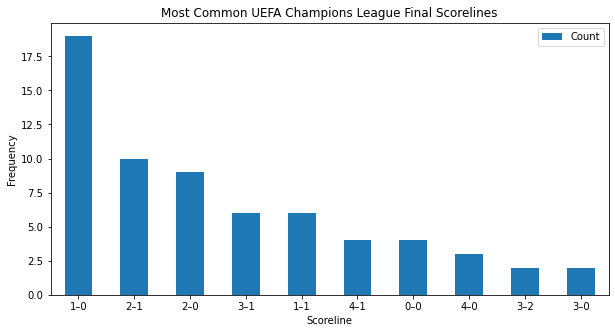

In [28]:
# Plot the top 10 most common scorelines in Champions League finals

score_counts.plot(kind='bar', x='Score', y='Count', figsize=(10, 5), title="Most Common UEFA Champions League Final Scorelines")
plt.xlabel("Scoreline")
plt.xticks(rotation=0)
plt.ylabel("Frequency")
plt.show()

In [29]:
# Count the occurrences of each match status type
match_status = df.value_counts('Match_Status').reset_index()
match_status.columns = ['Status', 'Count']

print(match_status)

         Status  Count
0  Regular Time     52
1     Penalties     11
2    Extra Time      5
3        Replay      1


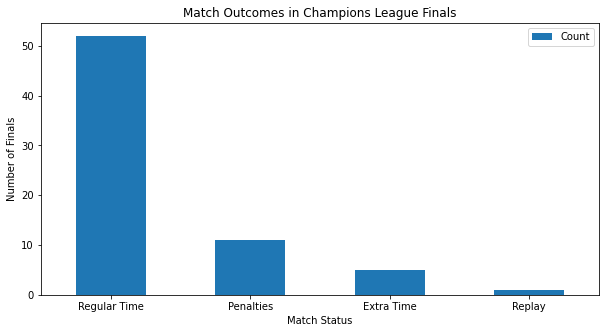

In [30]:
# Plot the distribution of match statuses in Champions League finals
match_status.plot(kind='bar', x='Status', y='Count',figsize=(10, 5), title="Match Outcomes in Champions League Finals")
plt.xlabel("Match Status")
plt.xticks(rotation=0)
plt.ylabel("Number of Finals")
plt.show()

#### Biggest Wins in Champions League Final History

In [31]:
# Show finals that ended with a goal difference of more than one goal

goal_difference_sorted = df.sort_values('Goal_Difference', ascending=False)

biggest_wins = goal_difference_sorted[['Season', 'Winners', 'Score', 'Runners-up', 'Goal_Difference', 'Match_Status']]

print(biggest_wins[biggest_wins.Goal_Difference > 1])

       Season            Winners Score                Runners-up  \
18    1973–74      Bayern Munich   4–0           Atlético Madrid   
4     1959–60        Real Madrid   7–3       Eintracht Frankfurt   
33    1988–89              Milan   4–0          Steaua București   
38    1993–94              Milan   4–0                 Barcelona   
58    2013–14        Real Madrid   4–1           Atlético Madrid   
61    2016–17        Real Madrid   4–1                  Juventus   
44  1999–2000        Real Madrid   3–0                  Valencia   
48    2003–04              Porto   3–0                    Monaco   
13    1968–69              Milan   4–1                      Ajax   
12    1967–68  Manchester United   4–1                   Benfica   
21    1976–77          Liverpool   3–1  Borussia Mönchengladbach   
53    2008–09          Barcelona   2–0         Manchester United   
55    2010–11          Barcelona   3–1         Manchester United   
54    2009–10        Inter Milan   2–0          

#### Most Competitive Finals

In [32]:
# Identify the most competitive finals (Finals decided by penalty kicks)
most_competitive_finals = df[df['Goal_Difference'] == df['Goal_Difference'].min()][['Season', 'Winners', 'Score', 'Runners-up', 'Match_Status']]

# Display the results
print(most_competitive_finals)

     Season            Winners Score       Runners-up Match_Status
28  1983–84          Liverpool   1–1             Roma    Penalties
30  1985–86   Steaua București   0–0        Barcelona    Penalties
32  1987–88      PSV Eindhoven   0–0          Benfica    Penalties
35  1990–91  Red Star Belgrade   0–0        Marseille    Penalties
40  1995–96           Juventus   1–1             Ajax    Penalties
45  2000–01      Bayern Munich   1–1         Valencia    Penalties
47  2002–03              Milan   0–0         Juventus    Penalties
49  2004–05          Liverpool   3–3         AC Milan    Penalties
52  2007–08  Manchester United   1–1          Chelsea    Penalties
56  2011–12            Chelsea   1–1    Bayern Munich    Penalties
60  2015–16        Real Madrid   1–1  Atlético Madrid    Penalties


# Most Frequent Runner-ups

#### Teams with the Most Runner-up Finishes

In [33]:
# Display the teams with more than once runner-up finishes in Champions League finals 

top_runner_ups = df['Runners-up'].value_counts().reset_index()
top_runner_ups.columns = ['Runner-up', 'Count']

print(top_runner_ups[top_runner_ups.Count > 1])

            Runner-up  Count
0            Juventus      7
1       Bayern Munich      5
2             Benfica      5
3           Liverpool      4
4            AC Milan      3
5           Barcelona      3
6         Real Madrid      3
7         Inter Milan      3
8     Atlético Madrid      3
9            Valencia      2
10              Reims      2
11  Manchester United      2
12               Ajax      2
13  Borussia Dortmund      2


#### Bar Chart of Most Runner-up Finishes

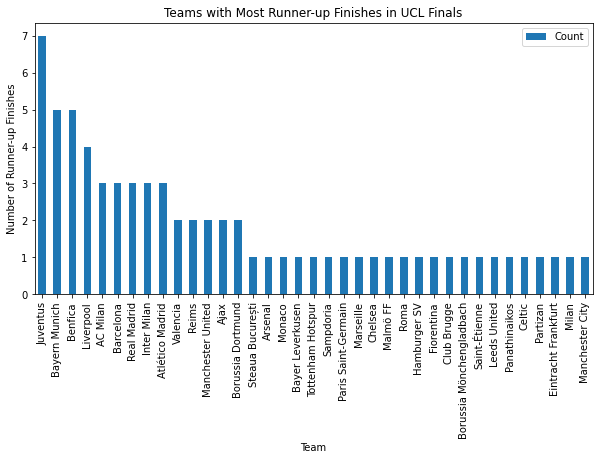

In [34]:
# Plot the top 10 teams with the most runner-up finishes in Champions League finals

top_runner_ups.plot(kind='bar', x='Runner-up', y='Count', figsize=(10, 5), title="Teams with Most Runner-up Finishes in UCL Finals")
plt.xlabel("Team")
plt.ylabel("Number of Runner-up Finishes")
plt.show()

# Highest-Scoring UEFA Champions League Finals

#### Top 10 Highest-Scoring Finals

In [35]:
# Sort and display the top 10 highest-scoring Champions League finals by total goals

most_goals_scored_finals = df.sort_values('Total_number_of_goals', ascending=False)[['Season', 'Total_number_of_goals']]
print(most_goals_scored_finals[:10])

     Season  Total_number_of_goals
4   1959–60                     10
6   1961–62                      8
0   1955–56                      7
49  2004–05                      6
12  1967–68                      5
61  2016–17                      5
13  1968–69                      5
58  2013–14                      5
2   1957–58                      5
5   1960–61                      5


#### Bar Chart of Highest-Scoring Finals

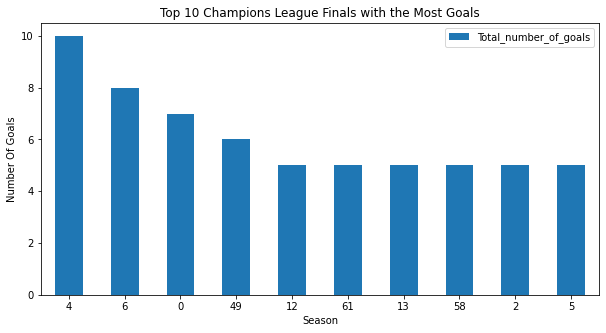

In [36]:
# Plot the top 10 highest-scoring Champions League finals

most_goals_scored_finals.head(10).plot(kind='bar', figsize=(10, 5), title="Top 10 Champions League Finals with the Most Goals", )
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.ylabel("Number Of Goals")
plt.show()

# The Most Frequent Matchups

In [37]:
# Group by Winners and Runners-up and aggregate the seasons
head_to_head_seasons = df.groupby(["Winners", "Runners-up"]) \
    .agg(Count=("Season", "count"), Seasons=("Season", lambda x: ", ".join(x))) \
    .reset_index()

# Sort by the most frequent matchups
head_to_head_seasons = head_to_head_seasons.sort_values(by="Count", ascending=False)

# Display matches that repeated more than once
print(head_to_head_seasons[head_to_head_seasons.Count > 1])

        Winners         Runners-up  Count           Seasons
55  Real Madrid           Juventus      2  1997–98, 2016–17
59  Real Madrid              Reims      2  1955–56, 1958–59
50  Real Madrid    Atlético Madrid      2  2013–14, 2015–16
41        Milan            Benfica      2  1962–63, 1989–90
7     Barcelona  Manchester United      2  2008–09, 2010–11
56  Real Madrid          Liverpool      2  2017–18, 2021–22


# Longest Winning and Runner-Up Streaks

#### Longest Consecutive Winning Streaks

In [38]:
# Initialize variables
streaks = {}
streak_seasons = {}
current_streak = 1
previous_winner = None
current_seasons = []

for _, row in df.iterrows():
    winner = row['Winners']
    season = row['Season']

    if winner == previous_winner:
        current_streak += 1
        current_seasons.append(season)
    else:
        if previous_winner is not None:
            # Store the longest streak and associated seasons
            if previous_winner not in streaks or streaks[previous_winner] < current_streak:
                streaks[previous_winner] = current_streak
                streak_seasons[previous_winner] = ', '.join(current_seasons)
        
        # Reset for the new team
        current_streak = 1
        current_seasons = [season]

    previous_winner = winner

# Capture the last recorded streak
if previous_winner and (previous_winner not in streaks or streaks[previous_winner] < current_streak):
    streaks[previous_winner] = current_streak
    streak_seasons[previous_winner] = ', '.join(current_seasons)

# Convert to DataFrame
streaks_df = pd.DataFrame(list(streaks.items()), columns=['Team', 'Longest_Winning_Streak'])
streaks_df['Seasons'] = streaks_df['Team'].map(streak_seasons)
streaks_df = streaks_df.sort_values(by='Longest_Winning_Streak', ascending=False)

# Display results
print(streaks_df[streaks_df.Longest_Winning_Streak > 1])

                 Team  Longest_Winning_Streak  \
0         Real Madrid                       5   
7                Ajax                       3   
8       Bayern Munich                       3   
2               Milan                       2   
3         Inter Milan                       2   
9           Liverpool                       2   
10  Nottingham Forest                       2   
1             Benfica                       2   

                                        Seasons  
0   1955–56, 1956–57, 1957–58, 1958–59, 1959–60  
7                     1970–71, 1971–72, 1972–73  
8                     1973–74, 1974–75, 1975–76  
2                              1988–89, 1989–90  
3                              1963–64, 1964–65  
9                              1976–77, 1977–78  
10                             1978–79, 1979–80  
1                              1960–61, 1961–62  


#### Longest Consecutive Runner-Up Streaks

In [39]:
# Initialize variables
runner_up_streaks = {}
runner_up_seasons = {}
current_streak = 1
previous_runner_up = None
current_seasons = []

for _, row in df.iterrows():
    runner_up = row['Runners-up']
    season = row['Season']

    if runner_up == previous_runner_up:
        current_streak += 1
        current_seasons.append(season)
    else:
        if previous_runner_up is not None:
            # Store the longest runner-up streak and associated seasons
            if previous_runner_up not in runner_up_streaks or runner_up_streaks[previous_runner_up] < current_streak:
                runner_up_streaks[previous_runner_up] = current_streak
                runner_up_seasons[previous_runner_up] = ', '.join(current_seasons)
        
        # Reset for the new team
        current_streak = 1
        current_seasons = [season]

    previous_runner_up = runner_up

# Capture the last recorded streak
if previous_runner_up and (previous_runner_up not in runner_up_streaks or runner_up_streaks[previous_runner_up] < current_streak):
    runner_up_streaks[previous_runner_up] = current_streak
    runner_up_seasons[previous_runner_up] = ', '.join(current_seasons)

# Convert to DataFrame
runner_up_df = pd.DataFrame(list(runner_up_streaks.items()), columns=['Team', 'Longest_Runner_Up_Streak'])
runner_up_df['Seasons'] = runner_up_df['Team'].map(runner_up_seasons)
runner_up_df = runner_up_df.sort_values(by='Longest_Runner_Up_Streak', ascending=False)

# Display results
print(runner_up_df[runner_up_df.Longest_Runner_Up_Streak > 1])

        Team  Longest_Runner_Up_Streak             Seasons
27  Valencia                         2  1999–2000, 2000–01
12  Juventus                         2    1996–97, 1997–98


# Win Rate Analysis

In [40]:
# Count the number of final appearances for each team (as winners and runners-up)
final_appearances = df['Winners'].value_counts() + df['Runners-up'].value_counts()

# Count the number of times each team won the final
titles_won = df['Winners'].value_counts()

# Create a DataFrame with final appearances and titles won
win_rate_df = pd.DataFrame({'Final_Appearances': final_appearances, 'Titles_Won': titles_won})

# Fill NaN values with 0 for teams that never won
win_rate_df = win_rate_df.fillna(0).astype(int)

# Calculate win rate as Titles Won / Final Appearances
win_rate_df['Win_Rate'] = (win_rate_df['Titles_Won'] / win_rate_df['Final_Appearances']) * 100

# Sort by number of final appearances
win_rate_df = win_rate_df.sort_values(by='Final_Appearances', ascending=False)

# Display the results
print(win_rate_df)

                          Final_Appearances  Titles_Won   Win_Rate
Real Madrid                              18          15  83.333333
Bayern Munich                            11           6  54.545455
Liverpool                                10           6  60.000000
Juventus                                  9           2  22.222222
Milan                                     8           7  87.500000
Barcelona                                 8           5  62.500000
Benfica                                   7           2  28.571429
Ajax                                      6           4  66.666667
Inter Milan                               6           3  50.000000
Manchester United                         5           3  60.000000
Chelsea                                   3           2  66.666667
Borussia Dortmund                         3           1  33.333333
Manchester City                           2           1  50.000000
Celtic                                    2           1  50.00

# Decade-Wise Analysis

#### Decade-Based Statistical Analysis

In [41]:
# Function to extract the decade from the season
def extract_decade(season):
    try:
        year = int(season[:4])  # Extract the first year from the season (e.g., "1999–2000" → 1999)
        return f"{(year // 10) * 10}s"  # Convert to decade format (e.g., 1990 → "1990s")
    except:
        return "Unknown"

# Apply the function to create a new Decade column
df['Decade'] = df['Season'].apply(extract_decade)

# Aggregate stats by decade
decade_analysis = df.groupby('Decade').agg(
    Total_Goals=('Total_number_of_goals', 'sum'),   # Sum of goals scored in finals per decade
    Average_Attendance=('Attendance', 'mean'),      # Average attendance per decade
    Unique_Winners=('Winners', pd.Series.nunique)   # Number of different winners per decade
).reset_index()

# Display the results
print(decade_analysis)

  Decade  Total_Goals  Average_Attendance  Unique_Winners
0  1950s           26             85772.0               1
1  1960s           40             56297.6               7
2  1970s           19             61858.0               4
3  1980s           14             64561.1               8
4  1990s           20             65870.2               9
5  2000s           26             65224.4               8
6  2010s           32             63052.8               5
7  2020s            5             61683.5               3


#### Country Dominance by Decade

In [42]:
# Count titles won by each country in each decade
country_dominance = df.groupby(['Decade', 'Winner_Country']).size().unstack(fill_value=0)

# Display the results
print(country_dominance)

Winner_Country  England  France  Germany  Italy  Netherlands  Portugal  \
Decade                                                                   
1950s                 0       0        0      0            0         0   
1960s                 1       0        0      4            1         2   
1970s                 4       0        0      0            3         0   
1980s                 3       0        0      3            1         1   
1990s                 1       1        1      2            1         0   
2000s                 2       0        1      3            0         1   
2010s                 2       0        2      0            0         0   
2020s                 2       0        0      0            0         0   

Winner_Country  Romania  Scotland  Spain  West Germany  Yugoslavia  
Decade                                                              
1950s                 0         0      5             0           0  
1960s                 0         1      1            

#### Bar Chart of Country Dominance Over Time

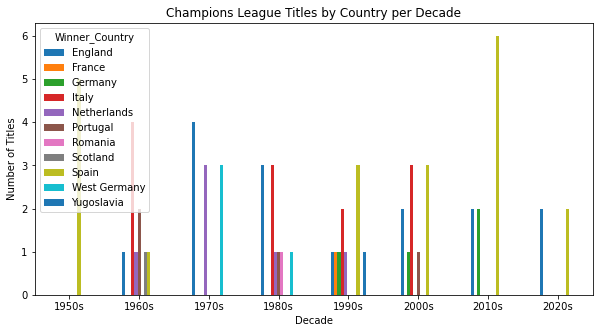

In [43]:
# Plot the number of Champions League titles won by each country per decade

country_dominance.head(10).plot(kind='bar', figsize=(10, 5), title="Champions League Titles by Country per Decade")
plt.xlabel("Decade")
plt.xticks(rotation=0)
plt.ylabel("Number of Titles")
plt.show()

# Top Cities And Countries Hosting UEFA Champions League Finals

#### Frequency of Final Hostings by City

In [44]:
# Count the number of finals hosted by each city
city_hosts = df['City'].value_counts().reset_index()
city_hosts.columns = ['City', 'Finals_Hosted']

# Display the results
print(city_hosts.head(10))  # Show the top 10 most common host cities

          City  Finals_Hosted
0       London              8
1       Madrid              5
2       Munich              4
3     Brussels              4
4         Rome              4
5       Vienna              4
6        Milan              4
7       Lisbon              3
8  Saint-Denis              3
9       Athens              3


#### Visualization of Common Final Host Cities

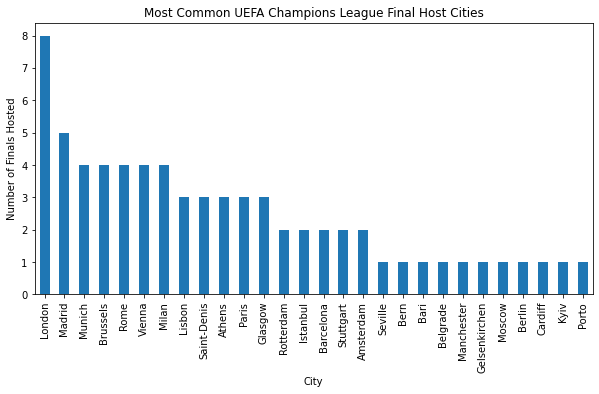

In [45]:
# Plot the most common final host cities
city_hosts.plot(kind='bar', x='City', y='Finals_Hosted', legend=False, figsize=(10, 5), title="Most Common UEFA Champions League Final Host Cities")

plt.xlabel("City")  # Label for x-axis
plt.ylabel("Number of Finals Hosted")  # Label for y-axis

plt.show()

#### Most Frequent Host Countries

In [46]:
# Count the number of finals hosted by each country
country_hosts = df['Host_Country'].value_counts().reset_index()
country_hosts.columns = ['Country', 'Finals_Hosted']

# Display the results
print(country_hosts.head(10))  # Show the top 10 most common host countries

       Country  Finals_Hosted
0        Italy              9
1      England              9
2        Spain              8
3       France              6
4      Germany              5
5  Netherlands              4
6      Austria              4
7      Belgium              4
8     Portugal              4
9     Scotland              3


#### Visualization of Common Final Host Countries

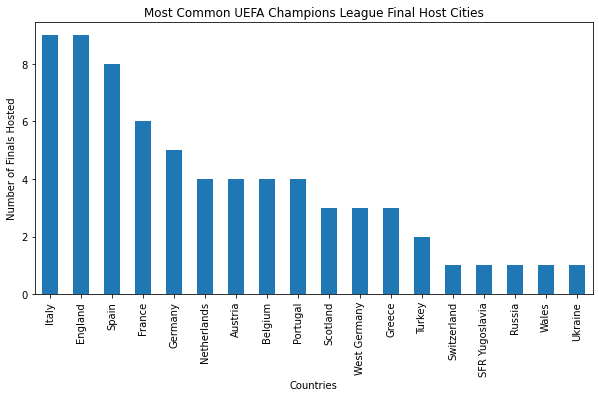

In [47]:
# Plot the most common final host cities
country_hosts.plot(kind='bar', x='Country', y='Finals_Hosted', legend=False, figsize=(10, 5), title="Most Common UEFA Champions League Final Host Cities")

plt.xlabel("Countries")  # Label for x-axis
plt.ylabel("Number of Finals Hosted")  # Label for y-axis

plt.show()

# Cities and Countries with the Highest UEFA Champions League Final Attendance

#### Cities with the Highest Total Final Attendance

In [48]:
# Calculate and display the top 10 cities with the highest total final match attendance

city_attendance = df.groupby('City')['Attendance'].sum().sort_values(ascending=False)
print(city_attendance.head(10))

City
London         644651
Madrid         343544
Milan          285629
Rome           259160
Munich         243400
Vienna         236121
Saint-Denis    234610
Glasgow        232984
Athens         206500
Brussels       195070
Name: Attendance, dtype: int32


#### Visualizing City Attendance

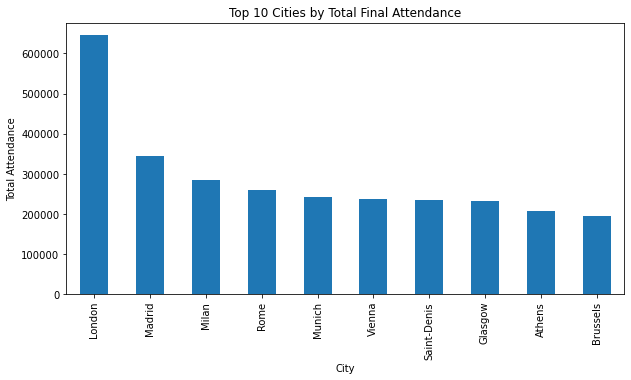

In [49]:
# Plot the top 10 teams with the highest final match attendance

city_attendance.head(10).plot(kind='bar', figsize=(10, 5), title="Top 10 Cities by Total Final Attendance")
plt.xlabel("City")
plt.ylabel("Total Attendance")
plt.show()

#### Countries with the Highest Total Final Attendance

In [50]:
# Calculate and display the top 10 countries with the highest total final match attendance

country_attendance = df.groupby('Host_Country')['Attendance'].sum().sort_values(ascending=False)
print(country_attendance.head(10))

Host_Country
England         706966
Italy           600789
Spain           600789
France          369583
Germany         309395
Austria         236121
Scotland        232984
Netherlands     217111
Greece          206500
West Germany    197500
Name: Attendance, dtype: int32


#### Visualizing Country Attendance

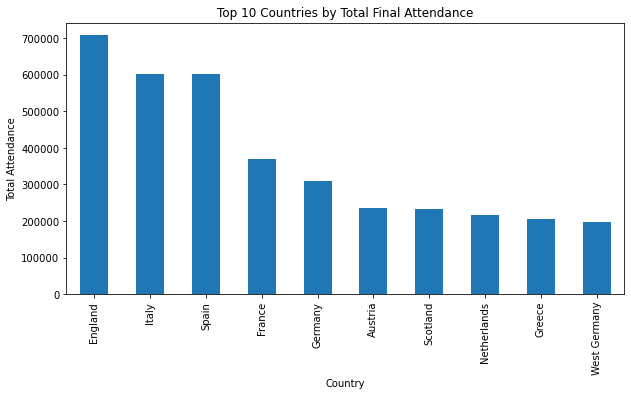

In [51]:
# Plot the top 10 teams with the highest final match attendance

country_attendance.head(10).plot(kind='bar', figsize=(10, 5), title="Top 10 Countries by Total Final Attendance")
plt.xlabel("Country")
plt.ylabel("Total Attendance")
plt.show()

# Impact of Home Advantage in UEFA Champions League Finals

#### Frequency of Home Advantage Wins

In [52]:
# Create a new column to check if the winner's country matches the stadium's country
df['Home_Advantage'] = df['Winner_Country'] == df['Host_Country']

# Count the number of finals where the winner had home advantage
home_wins = df['Home_Advantage'].value_counts().reset_index()
home_wins.columns = ['Home_Advantage', 'Count']

# Display the results
print(home_wins)

   Home_Advantage  Count
0           False     62
1            True      7


#### Visualizing Home Advantage Effect

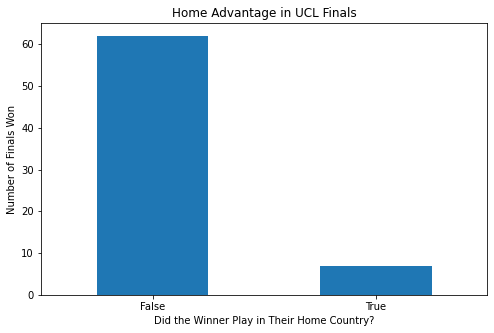

In [53]:
# Plot the results

home_wins.plot(kind='bar', x='Home_Advantage', y='Count', legend=False, figsize=(8, 5), title="Home Advantage in UCL Finals")
plt.xlabel("Did the Winner Play in Their Home Country?")
plt.ylabel("Number of Finals Won")
plt.xticks(rotation=0)  # Keep labels horizontal
plt.show()

#### Listing Finals with Home Advantage Wins

In [54]:
# Print only the finals where home advantage was true
home_advantage_finals = df[df['Home_Advantage'] == True][['Season', 'Winners', 'Runners-up','Stadium', 'Host_Country']]
print("\nFinals where the winning team had home advantage:\n")
print(home_advantage_finals)


Finals where the winning team had home advantage:

     Season            Winners   Runners-up            Stadium Host_Country
1   1956–57        Real Madrid   Fiorentina  Santiago Bernabéu        Spain
9   1964–65        Inter Milan      Benfica           San Siro        Italy
12  1967–68  Manchester United      Benfica    Wembley Stadium      England
16  1971–72               Ajax  Inter Milan            De Kuip  Netherlands
22  1977–78          Liverpool  Club Brugge    Wembley Stadium      England
40  1995–96           Juventus         Ajax    Stadio Olimpico        Italy
41  1996–97  Borussia Dortmund     Juventus     Olympiastadion      Germany


In [55]:
# Scrape European stadium capacity data from Wikipedia, extracting relevant columns
stadium_capacity = pd.concat([pd.read_html('https://en.wikipedia.org/wiki/List_of_European_stadiums_by_capacity')[i] 
                              for i in range(6)]).reset_index(drop=True)

# Rename the 'Name' column to 'Stadium' for consistency
stadium_capacity.rename(columns={'Name': 'Stadium'}, inplace=True)


# Function to extract the first numerical value from a text-based capacity entry
def extract_first_number(value):
    numbers = re.findall(r'\d{1,3}(?:,\d{3})*|\d+', value)  # Find numbers with thousands separator
    if numbers:
        first_number = numbers[0].replace(',', '')  # Remove commas from the number
        return first_number
    return None  # Return None if no valid number is found

# Identify rows where the 'Capacity' column contains non-numeric values
rows_need_cleaning = stadium_capacity[~stadium_capacity['Capacity'].astype(str).str.isdecimal()].index

# Apply the function to clean non-numeric values in the 'Capacity' column
stadium_capacity.loc[rows_need_cleaning, 'Capacity'] = stadium_capacity.loc[rows_need_cleaning, 'Capacity'].apply(lambda x: extract_first_number(x))

# Convert 'Capacity' column to integer for calculations
stadium_capacity['Capacity'] = stadium_capacity['Capacity'].astype(int)

# Display cleaned stadium capacity dataset
stadium_capacity

,Rank,Stadium,Capacity,City,Country,Tenants/notes,Built,UEFA category,Images,Image
0,1,Camp Nou,100000,Barcelona,Spain,"FC Barcelona, Spain national football teamUEFA...",1957,4[2][3],NaN,NaN
1,2,Wembley Stadium,90652,London,England,"England national football team 2011, 2013 and ...",2007,4[2][6][3],NaN,NaN
2,3,Santiago Bernabéu,85000,Madrid,Spain,"Real Madrid, Spain national football teamUEFA ...",1947,4[2][6][3],NaN,NaN
3,4,Twickenham Stadium,82500,London,England,England national rugby union team.1991 & 2015 ...,1907,NaN,NaN,NaN
4,5,Signal Iduna Park,81365,Dortmund,Germany,"Borussia Dortmund, Germany national football t...",1974,4[3],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
184,188,bet365 Stadium,30089,Stoke-on-Trent,England,Stoke City,1997,NaN,NaN,NaN
185,189,Stade de Genève,30084,Geneva,Switzerland,Servette FCUEFA Euro 2008 venue,2003,NaN,NaN,NaN
186,190,Estadio La Rosaleda,30044,Málaga,Spain,Málaga CF1982 FIFA World Cup venue,1941,4[46],NaN,NaN
187,191,Estádio D. Afonso Henriques,30029,Guimarães,Portugal,Vitória SCUEFA Euro 2004 venue2019 UEFA Nation...,1999,4[citation needed],NaN,NaN


- Make sure that there is no difference in the names of the stadiums, or that there are stadiums not on the list.

In [56]:
# Identify stadiums in the origanial data that are missing in stadium_capacity dataset
missing_stadiums = list(set(df.Stadium.unique()) - set(stadium_capacity.Stadium.unique()))

# Print stadiums that are not found in Wikipedia's stadium capacity dataset
print(missing_stadiums)

['Wankdorf Stadium', 'De Kuip', 'Praterstadion', 'Ramón Sánchez Pizjuán', 'Olympisch Stadion', 'Heysel Stadium', 'Amsterdam Arena', 'Ernst-Happel-Stadion', 'Neckarstadion', 'Olympic Stadium', 'Millennium Stadium', 'NSC Olimpiyskiy Stadium']


- These stadiums are not included in the list of European stadium capacities due to one of the possible following reasons:
    - The stadium name has changed.
    - Difference in the spelling of the stadium name
    - The stadium is not included in the list at all.

In [57]:
# pip install fuzzywuzzy

In [58]:
from fuzzywuzzy import fuzz, process

threshold = 75  # Minimum similarity score for matching
spelling_matches = {}

# Use fuzzy string matching to find close matches for missing stadiums
for stadium in missing_stadiums:
    best_match = process.extractOne(stadium, stadium_capacity['Stadium'].tolist(), scorer=fuzz.ratio)
    if best_match and best_match[1] >= threshold:  # If similarity is above threshold, accept match
        spelling_matches[stadium] = best_match[0]

# Print stadiums with possible name mismatches
print(spelling_matches)

{'Ramón Sánchez Pizjuán': 'Estadio Ramón Sánchez Pizjuán', 'Olympisch Stadion': 'Olympiastadion', 'Ernst-Happel-Stadion': 'Ernst Happel Stadion', 'Neckarstadion': 'ENEA Stadion', 'Olympic Stadium': 'Athens Olympic Stadium', 'NSC Olimpiyskiy Stadium': 'NSC Olimpiyskiy'}


C:\Users\Naser Rahal\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


- It seems that there are four stadiums different in the spelling.

In [59]:
# Dictionary to correct minor spelling/name differences
stadiums_difference_in_writing = {
    'Ernst-Happel-Stadion': 'Ernst Happel Stadion',
    'NSC Olimpiyskiy Stadium': 'NSC Olimpiyskiy',
    'Ramón Sánchez Pizjuán': 'Estadio Ramón Sánchez Pizjuán',
    'Olympic Stadium': 'Athens Olympic Stadium'
}

# Remove stadiums that have already been corrected from the missing stadiums list
missing_stadiums = [x for x in missing_stadiums if x not in stadiums_difference_in_writing.keys()]
print(missing_stadiums)

['Wankdorf Stadium', 'De Kuip', 'Praterstadion', 'Olympisch Stadion', 'Heysel Stadium', 'Amsterdam Arena', 'Neckarstadion', 'Millennium Stadium']


- By searching found that:
    - **Neckarstadion**: Known since 2023 as the `MHPArena`.
    - **Millennium Stadium**: Known since 2016 as the `Principality Stadium`.
    - **Praterstadion**: Known since 1992 as `Ernst-Happel-Stadion`.
    - *Olympisch Stadion: The name did not change.* 
    - **Amsterdam Arena**: Known since 2018 as `Johan Cruyff Arena`.
    - **De Kuip**: The nickname of `Stadion Feijenoord`.
    - *Wankdorf Stadium: The name did not change.*
    - **Heysel Stadium**: Known since 1995 as `The King Baudouin Stadium`.

In [60]:
lindex = []
for i in stadiums_difference_in_writing:
    for a in df[df.Stadium == i].index.values:
        lindex.append(a)

In [61]:
df.loc[lindex]

,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,Match_Status,Venue,Stadium,City,Host_Country,Attendance,Decade,Home_Advantage
39,1994–95,Netherlands,Ajax,1–0,AC Milan,Italy,1,0,1,1,Regular Time,"Ernst-Happel-Stadion, Vienna, Austria",Ernst-Happel-Stadion,Vienna,Austria,49730,1990s,False
62,2017–18,Spain,Real Madrid,3–1,Liverpool,England,3,1,2,4,Regular Time,"NSC Olimpiyskiy Stadium, Kyiv, Ukraine",NSC Olimpiyskiy Stadium,Kyiv,Ukraine,61561,2010s,False
30,1985–86,Romania,Steaua București,0–0,Barcelona,Spain,0,0,0,0,Penalties,"Ramón Sánchez Pizjuán, Seville, Spain",Ramón Sánchez Pizjuán,Seville,Spain,70000,1980s,False
27,1982–83,West Germany,Hamburger SV,1–0,Juventus,Italy,1,0,1,1,Regular Time,"Olympic Stadium, Athens, Greece",Olympic Stadium,Athens,Greece,73500,1980s,False
38,1993–94,Italy,Milan,4–0,Barcelona,Spain,4,0,4,4,Regular Time,"Olympic Stadium, Athens, Greece",Olympic Stadium,Athens,Greece,70000,1990s,False
51,2006–07,Italy,Milan,2–1,Liverpool,England,2,1,1,3,Regular Time,"Olympic Stadium, Athens, Greece",Olympic Stadium,Athens,Greece,63000,2000s,False


In [62]:
# Dictionary of stadiums that have been renamed over time
renamed_stadiums = {
    'Neckarstadion': 'MHPArena',
    'Millennium Stadium': 'Principality Stadium',
    'Praterstadion': 'Ernst Happel Stadion',
    'Amsterdam Arena': 'Johan Cruyff Arena',
    'De Kuip': 'Stadion Feijenoord',
    'Heysel Stadium': 'The King Baudouin Stadium'
}
   
for i in renamed_stadiums:
    for a in df[df.Stadium == i].index.values:
        lindex.append(a)

display(df.loc[lindex])

# Update stadium names in df using known name changes
df['Stadium'] = df['Stadium'].replace(stadiums_difference_in_writing)

# Append "(Renamed)" to stadiums that have changed names for clarity
df['Stadium'] = df['Stadium'].replace(renamed_stadiums)

# Merge cleaned stadium capacity data with df on 'Stadium'
df = df.merge(stadium_capacity[['Stadium','Capacity','City']], on='Stadium', how='left')

display(df.loc[lindex])

,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,Match_Status,Venue,Stadium,City,Host_Country,Attendance,Decade,Home_Advantage
39,1994–95,Netherlands,Ajax,1–0,AC Milan,Italy,1,0,1,1,Regular Time,"Ernst-Happel-Stadion, Vienna, Austria",Ernst-Happel-Stadion,Vienna,Austria,49730,1990s,False
62,2017–18,Spain,Real Madrid,3–1,Liverpool,England,3,1,2,4,Regular Time,"NSC Olimpiyskiy Stadium, Kyiv, Ukraine",NSC Olimpiyskiy Stadium,Kyiv,Ukraine,61561,2010s,False
30,1985–86,Romania,Steaua București,0–0,Barcelona,Spain,0,0,0,0,Penalties,"Ramón Sánchez Pizjuán, Seville, Spain",Ramón Sánchez Pizjuán,Seville,Spain,70000,1980s,False
27,1982–83,West Germany,Hamburger SV,1–0,Juventus,Italy,1,0,1,1,Regular Time,"Olympic Stadium, Athens, Greece",Olympic Stadium,Athens,Greece,73500,1980s,False
38,1993–94,Italy,Milan,4–0,Barcelona,Spain,4,0,4,4,Regular Time,"Olympic Stadium, Athens, Greece",Olympic Stadium,Athens,Greece,70000,1990s,False
51,2006–07,Italy,Milan,2–1,Liverpool,England,2,1,1,3,Regular Time,"Olympic Stadium, Athens, Greece",Olympic Stadium,Athens,Greece,63000,2000s,False
3,1958–59,Spain,Real Madrid,2–0,Reims,France,2,0,2,2,Regular Time,"Neckarstadion, Stuttgart, West Germany",Neckarstadion,Stuttgart,West Germany,72000,1950s,False
32,1987–88,Netherlands,PSV Eindhoven,0–0,Benfica,Portugal,0,0,0,0,Penalties,"Neckarstadion, Stuttgart, West Germany",Neckarstadion,Stuttgart,West Germany,68000,1980s,False
61,2016–17,Spain,Real Madrid,4–1,Juventus,Italy,4,1,3,5,Regular Time,"Millennium Stadium, Cardiff, Wales",Millennium Stadium,Cardiff,Wales,65842,2010s,False
8,1963–64,Italy,Inter Milan,3–1,Real Madrid,Spain,3,1,2,4,Regular Time,"Praterstadion, Vienna, Austria",Praterstadion,Vienna,Austria,71333,1960s,False


,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,Match_Status,Venue,Stadium,City_x,Host_Country,Attendance,Decade,Home_Advantage,Capacity,City_y
39,1992–93,France,Marseille,1–0,AC Milan,Italy,1,0,1,1,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,64400,1990s,False,63118.0,Munich
62,2014–15,Spain,Barcelona,3–1,Juventus,Italy,3,1,2,4,Regular Time,"Olympiastadion, Berlin, Germany",Olympiastadion,Berlin,Germany,70442,2010s,False,71000.0,Berlin
30,1984–85,Italy,Juventus,1–0,Liverpool,England,1,0,1,1,Regular Time,"Heysel Stadium, Brussels, Belgium",The King Baudouin Stadium,Brussels,Belgium,58000,1980s,False,NaN,NaN
27,1981–82,England,Aston Villa,1–0,Bayern Munich,West Germany,1,0,1,1,Regular Time,"De Kuip, Rotterdam, Netherlands",Stadion Feijenoord,Rotterdam,Netherlands,46000,1980s,False,47500.0,Rotterdam
38,1992–93,France,Marseille,1–0,AC Milan,Italy,1,0,1,1,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,64400,1990s,False,71000.0,Berlin
51,2003–04,Portugal,Porto,3–0,Monaco,France,3,0,3,3,Regular Time,"Arena AufSchalke, Gelsenkirchen, Germany",Arena AufSchalke,Gelsenkirchen,Germany,53053,2000s,False,50000.0,Gelsenkirchen
3,1958–59,Spain,Real Madrid,2–0,Reims,France,2,0,2,2,Regular Time,"Neckarstadion, Stuttgart, West Germany",MHPArena,Stuttgart,West Germany,72000,1950s,False,51000.0,Stuttgart
32,1986–87,Portugal,Porto,2–1,Bayern Munich,West Germany,2,1,1,3,Regular Time,"Praterstadion, Vienna, Austria",Ernst Happel Stadion,Vienna,Austria,57500,1980s,False,50865.0,Vienna
61,2013–14,Spain,Real Madrid,4–1,Atlético Madrid,Spain,4,1,3,5,Extra Time,"Estádio da Luz, Lisbon, Portugal",Estádio da Luz,Lisbon,Portugal,60976,2010s,False,65592.0,Lisbon
8,1963–64,Italy,Inter Milan,3–1,Real Madrid,Spain,3,1,2,4,Regular Time,"Praterstadion, Vienna, Austria",Ernst Happel Stadion,Vienna,Austria,71333,1960s,False,50865.0,Vienna


- Since both data frames have a column with the same name, **pandas automatically differentiates them** by appending suffixes:
    - `"City_x"` refers to the `"City"` column from the **original data frame**.
    - `"City_y"` refers to the `"City"` column from the **stadium capacity data frame**.


- The original data is 69 row, while the mergerd data is 73, so there is a 4 rows more. Lets check what happen.

In [63]:
# Print rows where the same season appears more than once (duplicates)
display(df[df.Season.duplicated(keep=False)])

,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,Match_Status,Venue,Stadium,City_x,Host_Country,Attendance,Decade,Home_Advantage,Capacity,City_y
23,1978–79,England,Nottingham Forest,1–0,Malmö FF,Sweden,1,0,1,1,Regular Time,"Olympiastadion, Munich, West Germany",Olympiastadion,Munich,West Germany,57500,1970s,False,71000.0,Berlin
24,1978–79,England,Nottingham Forest,1–0,Malmö FF,Sweden,1,0,1,1,Regular Time,"Olympiastadion, Munich, West Germany",Olympiastadion,Munich,West Germany,57500,1970s,False,63118.0,Munich
38,1992–93,France,Marseille,1–0,AC Milan,Italy,1,0,1,1,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,64400,1990s,False,71000.0,Berlin
39,1992–93,France,Marseille,1–0,AC Milan,Italy,1,0,1,1,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,64400,1990s,False,63118.0,Munich
43,1996–97,Germany,Borussia Dortmund,3–1,Juventus,Italy,3,1,2,4,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,59000,1990s,True,71000.0,Berlin
44,1996–97,Germany,Borussia Dortmund,3–1,Juventus,Italy,3,1,2,4,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,59000,1990s,True,63118.0,Munich
62,2014–15,Spain,Barcelona,3–1,Juventus,Italy,3,1,2,4,Regular Time,"Olympiastadion, Berlin, Germany",Olympiastadion,Berlin,Germany,70442,2010s,False,71000.0,Berlin
63,2014–15,Spain,Barcelona,3–1,Juventus,Italy,3,1,2,4,Regular Time,"Olympiastadion, Berlin, Germany",Olympiastadion,Berlin,Germany,70442,2010s,False,63118.0,Munich


In Germany, there are two stadiums called **Olympiastadion**—one in **Berlin** and one in **Munich**—is that both were built for separate Olympic Games.

1. **Olympiastadion Berlin (1936)**  
   - Built for the **1936 Summer Olympics**, hosted by Nazi Germany.
   - Designed as part of the massive Reichssportfeld sports complex.
   - Became a historic venue, hosting events such as the **2006 FIFA World Cup Final**.
   - Still in use today for major sports events, concerts, and as the home of **Hertha BSC**.

2. **Olympiastadion Munich (1972)**  
   - Constructed for the **1972 Summer Olympics**.
   - Notable for its revolutionary **tent-like roof** design by Frei Otto.
   - Originally home to **Bayern Munich** and **1860 Munich** until the Allianz Arena was built.
   - Now used for concerts, events, and recreational sports.

- Since both stadiums were built for the Olympics and retained their original names, they both carry the **"Olympiastadion"** designation.

- Let's check rows that differ in the city name. Also, the capacity should not be null (because if it is null, that means the stadium is not included in the list at all).

In [64]:
# Identify records where city names don't match after merging
display(df[(df.City_x != df.City_y) & (~df.Capacity.isnull())])

,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,Match_Status,Venue,Stadium,City_x,Host_Country,Attendance,Decade,Home_Advantage,Capacity,City_y
11,1966–67,Scotland,Celtic,2–1,Inter Milan,Italy,2,1,1,3,Regular Time,"Estádio Nacional, Lisbon, Portugal",Estádio Nacional,Lisbon,Portugal,45000,1960s,False,37593.0,Oeiras
23,1978–79,England,Nottingham Forest,1–0,Malmö FF,Sweden,1,0,1,1,Regular Time,"Olympiastadion, Munich, West Germany",Olympiastadion,Munich,West Germany,57500,1970s,False,71000.0,Berlin
38,1992–93,France,Marseille,1–0,AC Milan,Italy,1,0,1,1,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,64400,1990s,False,71000.0,Berlin
43,1996–97,Germany,Borussia Dortmund,3–1,Juventus,Italy,3,1,2,4,Regular Time,"Olympiastadion, Munich, Germany",Olympiastadion,Munich,Germany,59000,1990s,True,71000.0,Berlin
63,2014–15,Spain,Barcelona,3–1,Juventus,Italy,3,1,2,4,Regular Time,"Olympiastadion, Berlin, Germany",Olympiastadion,Berlin,Germany,70442,2010s,False,63118.0,Munich


- The Estádio Nacional it is located in the civil parish of Algés, Linda-a-Velha e Cruz Quebrada-Dafundo, in the municipality of Oeiras, in the southwestern part of Lisbon District. Oeiras is a town and municipality in the western part of Lisbon metropolitan area, located within the Portuguese Riviera, in continental Portugal. So we need to remove the 23, 38, 43, 63 rows.

In [65]:
# Drop problematic rows (manual correction)
df = df.drop([23, 38, 43, 63]).reset_index(drop=True)

# Rename columns to resolve duplicate city names from merging
df.rename(columns={"City_x": "City", 'Capacity':'Stadium_Capacity'}, inplace=True)
df.drop('City_y', axis=1, inplace=True)

df

,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,Match_Status,Venue,Stadium,City,Host_Country,Attendance,Decade,Home_Advantage,Stadium_Capacity
0,1955–56,Spain,Real Madrid,4–3,Reims,France,4,3,1,7,Regular Time,"Parc des Princes, Paris, France",Parc des Princes,Paris,France,38239,1950s,False,48229.0
1,1956–57,Spain,Real Madrid,2–0,Fiorentina,Italy,2,0,2,2,Regular Time,"Santiago Bernabéu, Madrid, Spain",Santiago Bernabéu,Madrid,Spain,124000,1950s,True,85000.0
2,1957–58,Spain,Real Madrid,3–2,Milan,Italy,3,2,1,5,Extra Time,"Heysel Stadium, Brussels, Belgium",The King Baudouin Stadium,Brussels,Belgium,67000,1950s,False,NaN
3,1958–59,Spain,Real Madrid,2–0,Reims,France,2,0,2,2,Regular Time,"Neckarstadion, Stuttgart, West Germany",MHPArena,Stuttgart,West Germany,72000,1950s,False,51000.0
4,1959–60,Spain,Real Madrid,7–3,Eintracht Frankfurt,West Germany,7,3,4,10,Regular Time,"Hampden Park, Glasgow, Scotland",Hampden Park,Glasgow,Scotland,127621,1950s,False,52032.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2019–20,Germany,Bayern Munich,1–0,Paris Saint-Germain,France,1,0,1,1,Regular Time,"Estádio da Luz, Lisbon, Portugal",Estádio da Luz,Lisbon,Portugal,0,2010s,False,65592.0
65,2020–21,England,Chelsea,1–0,Manchester City,England,1,0,1,1,Regular Time,"Estádio do Dragão, Porto, Portugal",Estádio do Dragão,Porto,Portugal,14110,2020s,False,50033.0
66,2021–22,Spain,Real Madrid,1–0,Liverpool,England,1,0,1,1,Regular Time,"Stade de France, Saint-Denis, France",Stade de France,Saint-Denis,France,75000,2020s,False,81338.0
67,2022–23,England,Manchester City,1–0,Inter Milan,Italy,1,0,1,1,Regular Time,"Atatürk Olympic Stadium, Istanbul, Turkey",Atatürk Olympic Stadium,Istanbul,Turkey,71412,2020s,False,77563.0


In [66]:
# Calculate stadium attendance percentage
df['Attendance_Percentage'] = (df['Attendance'] / df['Stadium_Capacity']) * 100

# Display top 10 matches with the highest attendance percentage
d = df.sort_values('Attendance_Percentage', ascending=False)[['Season', 'Stadium', 'Attendance', 'Stadium_Capacity', 'Attendance_Percentage']]
d[:10]

,Season,Stadium,Attendance,Stadium_Capacity,Attendance_Percentage
4,1959–60,Hampden Park,127621,52032.0,245.274062
17,1972–73,Red Star Stadium,89484,53000.0,168.837736
1,1956–57,Santiago Bernabéu,124000,85000.0,145.882353
3,1958–59,MHPArena,72000,51000.0,141.176471
8,1963–64,Ernst Happel Stadion,71333,50865.0,140.239851
32,1987–88,MHPArena,68000,51000.0,133.333333
16,1971–72,Stadion Feijenoord,61354,47500.0,129.166316
30,1985–86,Estadio Ramón Sánchez Pizjuán,70000,55000.0,127.272727
9,1964–65,San Siro,89000,70000.0,127.142857
11,1966–67,Estádio Nacional,45000,37593.0,119.703136


- The reason there are percentages greater than 100 is that the stadium capacity may have been reduced, or there may be an error from the data source itself, so the number may not be accurate.

In [67]:
winning_managers_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_European_Cup_and_UEFA_Champions_League_winning_managers#By_year')[0]

winning_managers_list = winning_managers_list.rename(columns = {'Winning manager': 'Winning_Manager'})

winning_managers_list

,Final,Nationality,Winning_Manager,Nation,Club,Ref.
0,1956,Spain,José Villalonga,Spain,Real Madrid,[6]
1,1957,Spain,José Villalonga,Spain,Real Madrid,[6]
2,1958,Argentina,Luis Carniglia,Spain,Real Madrid,[6]
3,1959,Argentina,Luis Carniglia,Spain,Real Madrid,[6]
4,1960,Spain,Miguel Muñoz,Spain,Real Madrid,[6]
...,...,...,...,...,...,...
64,2020,Germany,Hansi Flick,Germany,Bayern Munich,[44]
65,2021,Germany,Thomas Tuchel,England,Chelsea,[45]
66,2022,Italy,Carlo Ancelotti,Spain,Real Madrid,[46]
67,2023,Spain,Pep Guardiola,England,Manchester City,[47]


In [68]:
df = df.merge(winning_managers_list['Winning_Manager'], left_index=True, right_index=True)

In [69]:
# winning_managers_list = df.value_counts('Winning_Manager', ascending = False)

# filtered_managers = winning_managers_list[winning_managers_list > 1]

# filtered_managers.plot(kind='bar', legend=False, figsize=(8, 5), title="Most Winning Managers")
# plt.xlabel("The Maneger")
# plt.ylabel("Number of Title")
# plt.savefig("winning_managers_chart.png")
# plt.show()
# winning_managers_list

In [72]:
df

,Season,Winner_Country,Winners,Score,Runners-up,Runner_Up_Country,Winner_Score,Loser_Score,Goal_Difference,Total_number_of_goals,...,Venue,Stadium,City,Host_Country,Attendance,Decade,Home_Advantage,Stadium_Capacity,Attendance_Percentage,Winning_Manager
0,1955–56,Spain,Real Madrid,4–3,Reims,France,4,3,1,7,...,"Parc des Princes, Paris, France",Parc des Princes,Paris,France,38239,1950s,False,48229.0,79.286322,José Villalonga
1,1956–57,Spain,Real Madrid,2–0,Fiorentina,Italy,2,0,2,2,...,"Santiago Bernabéu, Madrid, Spain",Santiago Bernabéu,Madrid,Spain,124000,1950s,True,85000.0,145.882353,José Villalonga
2,1957–58,Spain,Real Madrid,3–2,Milan,Italy,3,2,1,5,...,"Heysel Stadium, Brussels, Belgium",The King Baudouin Stadium,Brussels,Belgium,67000,1950s,False,NaN,NaN,Luis Carniglia
3,1958–59,Spain,Real Madrid,2–0,Reims,France,2,0,2,2,...,"Neckarstadion, Stuttgart, West Germany",MHPArena,Stuttgart,West Germany,72000,1950s,False,51000.0,141.176471,Luis Carniglia
4,1959–60,Spain,Real Madrid,7–3,Eintracht Frankfurt,West Germany,7,3,4,10,...,"Hampden Park, Glasgow, Scotland",Hampden Park,Glasgow,Scotland,127621,1950s,False,52032.0,245.274062,Miguel Muñoz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2019–20,Germany,Bayern Munich,1–0,Paris Saint-Germain,France,1,0,1,1,...,"Estádio da Luz, Lisbon, Portugal",Estádio da Luz,Lisbon,Portugal,0,2010s,False,65592.0,0.000000,Hansi Flick
65,2020–21,England,Chelsea,1–0,Manchester City,England,1,0,1,1,...,"Estádio do Dragão, Porto, Portugal",Estádio do Dragão,Porto,Portugal,14110,2020s,False,50033.0,28.201387,Thomas Tuchel
66,2021–22,Spain,Real Madrid,1–0,Liverpool,England,1,0,1,1,...,"Stade de France, Saint-Denis, France",Stade de France,Saint-Denis,France,75000,2020s,False,81338.0,92.207824,Carlo Ancelotti
67,2022–23,England,Manchester City,1–0,Inter Milan,Italy,1,0,1,1,...,"Atatürk Olympic Stadium, Istanbul, Turkey",Atatürk Olympic Stadium,Istanbul,Turkey,71412,2020s,False,77563.0,92.069672,Pep Guardiola
